In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove-6b-100-d/glove.6B.100d.txt
/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [2]:
import pandas as pd

In [3]:
dataset=pd.read_csv(r"/kaggle/input/amazon-fine-food-reviews/Reviews.csv")

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
dataset.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
print(dataset[['Score','Text']].head(5))

   Score                                               Text
0      5  I have bought several of the Vitality canned d...
1      1  Product arrived labeled as Jumbo Salted Peanut...
2      4  This is a confection that has been around a fe...
3      2  If you are looking for the secret ingredient i...
4      5  Great taffy at a great price.  There was a wid...


In [7]:
print(dataset.isna().sum())

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


In [8]:
lmtpData=dataset[['Text','Summary','Score']].sample(n=1000)
print(lmtpData)

                                                     Text  \
237845  I've tried several goji berries on Amazon and ...   
154346  it's like the red nyquil.  yuck. I bake a lot ...   
11855   Good solid product.  Saves room when storing y...   
366452  This is a great decaf green tea. I decided to ...   
353445  These are the best vanilla protein bars that I...   
...                                                   ...   
202092  I had recently tried the regular cheddar bunni...   
96973   These Mini Marshmallows are great for my produ...   
110628  Once a diehard bean-grinder, I'm now a convert...   
291288  I have Arthritis  and sometimes it's very hard...   
510737  Really great bold flavour, my favourite out of...   

                                   Summary  Score  
237845                          Very good!      5  
154346                     tastes terrible      1  
11855                               cescob      5  
366452  Great Green Tea and Great Company!      5  
353445 

### ADDING SENTIMENT COLUMN

In [9]:
#0-negative, 1-positive
def lblScore(score):
    if score<=2:
        return 0
    elif score>=4:
        return 1
    else:
        return 2
lmtpData['Sentiment']=lmtpData['Score'].apply(lblScore)
lmtpData.head(5)

,Text,Summary,Score,Sentiment
237845,I've tried several goji berries on Amazon and ...,Very good!,5,1
154346,it's like the red nyquil. yuck. I bake a lot ...,tastes terrible,1,0
11855,Good solid product. Saves room when storing y...,cescob,5,1
366452,This is a great decaf green tea. I decided to ...,Great Green Tea and Great Company!,5,1
353445,These are the best vanilla protein bars that I...,power crunch protein bars,5,1


In [10]:
lmtpData['Sentiment'].value_counts()

Sentiment
1    771
0    154
2     75
Name: count, dtype: int64

#### VECTORS

In [11]:
import numpy as np

glove_path = "/kaggle/input/glove-6b-100-d/glove.6B.100d.txt"

def loadGloveEmbeddings(filePath, embedding_dim=100):
    embeddingsIndex = {}
    with open(filePath, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddingsIndex[word] = coefs
    return embeddingsIndex

gloveEmbeddings = loadGloveEmbeddings(glove_path)
print("Loaded {} word vectors.".format(len(gloveEmbeddings)))


        

Loaded 400000 word vectors.


#### CREATING EMBEDDING MATRIX

In [12]:
lmtpData['Summary']=lmtpData['Summary'].fillna("")
lmtpData['CombinedText']=lmtpData['Summary'] + " " + lmtpData['Text']


In [13]:
#tokenizing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer=Tokenizer()
tokenizer.fit_on_texts(lmtpData['CombinedText'])
sequences=tokenizer.texts_to_sequences(lmtpData['CombinedText'])

maxLen=100
padded_sequences=pad_sequences(sequences,maxlen=maxLen,padding='post')

In [14]:
embedding_dim=100
vocabSize=len(tokenizer.word_index) + 1

embeddingMatrix=np.zeros((vocabSize,embedding_dim))

for word,i in tokenizer.word_index.items():
    embeddingVector=gloveEmbeddings.get(word)
    if embeddingVector is not None:
        embeddingMatrix[i]=embeddingVector

In [15]:
print("Embedding matrix shape:", embeddingMatrix.shape)


Embedding matrix shape: (7107, 100)


### MAKING THE MODEL

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Input
maxLen=100
X_train = padded_sequences 
y_train = lmtpData["Sentiment"].values  

print("Padded shape:", X_train.shape)  
print("Labels shape:", y_train.shape) 

model = Sequential([
    Input(shape=(maxLen,)),
    Embedding(input_dim=vocabSize,  
              output_dim=embedding_dim, 
              weights=embeddingMatrix, 
             
              trainable=False), 
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dropout(0.3),
    Dense(3, activation='softmax') 
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Padded shape: (1000, 100)
Labels shape: (1000,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 100)            │         710,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 877,551 (3.35 MB)

 Trainable params: 166,851 (651.76 KB)

 Non-trainable params: 710,700 (2.71 MB)

In [17]:

history=model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.3)



Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.6883 - loss: 0.9824 - val_accuracy: 0.7933 - val_loss: 0.6389
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.7565 - loss: 0.7178 - val_accuracy: 0.7933 - val_loss: 0.6346
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.7831 - loss: 0.6549 - val_accuracy: 0.7933 - val_loss: 0.6407
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.7681 - loss: 0.6951 - val_accuracy: 0.7933 - val_loss: 0.6391
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.7811 - loss: 0.6743 - val_accuracy: 0.7933 - val_loss: 0.6399
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.7722 - loss: 0.6629 - val_accuracy: 0.7933 - val_loss: 0.6437
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.7600 - loss: 0.6907 - val_accuracy: 0.7933 - val_loss: 0.6332
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.7736 - loss: 0.6894 - val_accuracy: 0.

#### PLOTTING AND ACCURACY AND LOSS CURVES

In [18]:
import matplotlib.pyplot as plt
accuracy=history.history['accuracy']
valAccuracy=history.history['val_accuracy']
loss = history.history['loss']
valLoss = history.history['val_loss']
epochs_range = range(1, len(accuracy) + 1)

Text(0.5, 1.0, 'Training & Validation Accuracy')

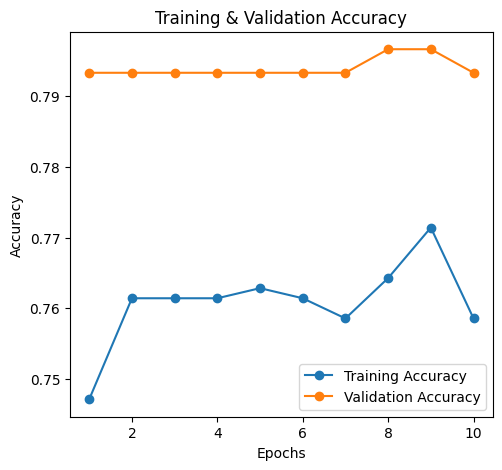

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs_range, valAccuracy, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')

Text(0.5, 1.0, 'Training & Validation Loss')

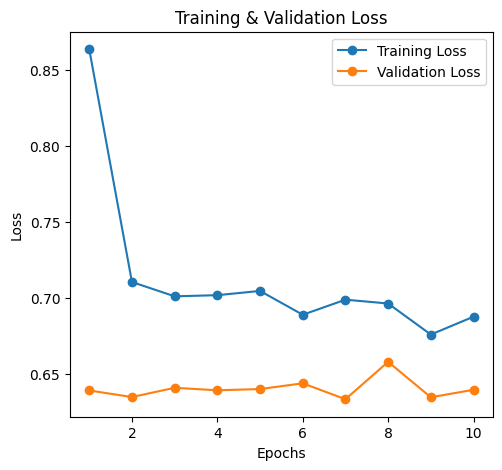

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, valLoss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')

##### overfitting

### OUTPUT VS PREDICTED OUTPUT


In [21]:
predictions=model.predict(padded_sequences)
predictedClasses=np.argmax(predictions,axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step


In [22]:
comparisonData=pd.DataFrame({
    "Text":lmtpData["CombinedText"],
    "Actual Sentiment":lmtpData["Sentiment"].values,
    "Predicted Sentiment":predictedClasses
})
comparisonData.head(10)

,Text,Actual Sentiment,Predicted Sentiment
237845,Very good! I've tried several goji berries on ...,1,1
154346,tastes terrible it's like the red nyquil. yuc...,0,1
11855,cescob Good solid product. Saves room when st...,1,1
366452,Great Green Tea and Great Company! This is a g...,1,1
353445,power crunch protein bars These are the best v...,1,1
56486,Good Quality Wild Rice... Good quality wild ri...,2,1
331173,"One of the best K Cups, but buy elsewhere! If ...",1,1
458895,"Delicious! A MUST re-order! Fresh, and delish...",1,1
43042,Kenya AA - yawn :-O Kenyan is one of my favori...,2,1
501647,I'm noticing a trend here... EVERY candy I hav...,1,1


In [23]:
comparisonData.head(20)

,Text,Actual Sentiment,Predicted Sentiment
237845,Very good! I've tried several goji berries on ...,1,1
154346,tastes terrible it's like the red nyquil. yuc...,0,1
11855,cescob Good solid product. Saves room when st...,1,1
366452,Great Green Tea and Great Company! This is a g...,1,1
353445,power crunch protein bars These are the best v...,1,1
56486,Good Quality Wild Rice... Good quality wild ri...,2,1
331173,"One of the best K Cups, but buy elsewhere! If ...",1,1
458895,"Delicious! A MUST re-order! Fresh, and delish...",1,1
43042,Kenya AA - yawn :-O Kenyan is one of my favori...,2,1
501647,I'm noticing a trend here... EVERY candy I hav...,1,1


In [24]:
comparisonData.to_csv("PredictedSample1.csv", index=False)


## TRAINING USING NEW SAMPLE DATASET

In [25]:
droppedData=dataset.drop(lmtpData.index)
dataset2=droppedData.sample(1000,random_state=43)
dataset2.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150195,150196,B006YJW6TO,A33D8UR5GTR7TV,"J. Karpf ""smart guy""",1,1,5,1336694400,Who knew?,Who knew these two flavors would blend togethe...
541137,541138,B000FMTJJQ,A27WPNZY7T8ZG8,"Blindy ""blindy53""",0,0,5,1194048000,Sweet Nectar,Excellent sweetener for those that want to sta...
480355,480356,B000DZDJ0K,AU4SGJS71ZV55,Charlotta HIbbs,0,0,5,1304380800,Great waffles...,This gluten-free flour mix is great for waffle...
363038,363039,B0049WV8S8,A167UHMJNSOHFN,Joe Donahou,0,0,5,1346803200,Fry'en Bacon,I bought this microwave bacon tray after my fr...
555895,555896,B004E7A33E,A1OXWH79Y58DB5,flipflop,2,4,2,1320796800,Main ingredient says natural blueberry flavor,I love Olive Nation's Strawberry extract; howe...


In [26]:
lmtpData2=dataset2[['Score','Summary','Text']]
lmtpData2.head()

,Score,Summary,Text
150195,5,Who knew?,Who knew these two flavors would blend togethe...
541137,5,Sweet Nectar,Excellent sweetener for those that want to sta...
480355,5,Great waffles...,This gluten-free flour mix is great for waffle...
363038,5,Fry'en Bacon,I bought this microwave bacon tray after my fr...
555895,2,Main ingredient says natural blueberry flavor,I love Olive Nation's Strawberry extract; howe...


In [27]:
lmtpData2 = lmtpData2.copy()
lmtpData2['Summary'] = lmtpData2['Summary'].fillna("")
lmtpData2['CombinedText'] = lmtpData2['Summary'] + " " + lmtpData2['Text']


In [28]:
lmtpData2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 150195 to 28993
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Score         1000 non-null   int64 
 1   Summary       1000 non-null   object
 2   Text          1000 non-null   object
 3   CombinedText  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.1+ KB


In [29]:

lmtpData2['Sentiment']=lmtpData2['Score'].apply(lblScore)
lmtpData2.head(5)

,Score,Summary,Text,CombinedText,Sentiment
150195,5,Who knew?,Who knew these two flavors would blend togethe...,Who knew? Who knew these two flavors would ble...,1
541137,5,Sweet Nectar,Excellent sweetener for those that want to sta...,Sweet Nectar Excellent sweetener for those tha...,1
480355,5,Great waffles...,This gluten-free flour mix is great for waffle...,Great waffles... This gluten-free flour mix is...,1
363038,5,Fry'en Bacon,I bought this microwave bacon tray after my fr...,Fry'en Bacon I bought this microwave bacon tra...,1
555895,2,Main ingredient says natural blueberry flavor,I love Olive Nation's Strawberry extract; howe...,Main ingredient says natural blueberry flavor ...,0


In [30]:
tokenizer.fit_on_texts(lmtpData2['CombinedText'])
sequences=tokenizer.texts_to_sequences(lmtpData2['CombinedText'])

maxLen=100
paddedData=pad_sequences(sequences,maxlen=maxLen,padding='post')
embedding_dim=100
vocabSize=len(tokenizer.word_index) + 1

embeddingMatrix2=np.zeros((vocabSize,embedding_dim))

for word,i in tokenizer.word_index.items():
    embeddingVector2=gloveEmbeddings.get(word)
    if embeddingVector2 is not None:
        embeddingMatrix2[i]=embeddingVector2

### BALANCING THE CLASSES

In [31]:
from imblearn.over_sampling import SMOTE


y2 = lmtpData2['Sentiment'].values


smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(paddedData, y2)


In [32]:
maxLen=100
model = Sequential([
    Input(shape=(maxLen,)),
    Embedding(input_dim=vocabSize,  
              output_dim=embedding_dim, 
              weights=embeddingMatrix2, 
             
              trainable=False), 
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dropout(0.6),
    Dense(3, activation='softmax') 
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 100)            │         997,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,164,651 (4.44 MB)

 Trainable params: 166,851 (651.76 KB)

 Non-trainable params: 997,800 (3.81 MB)

In [33]:
model.fit(X_resampled, Y_resampled, epochs=6, batch_size=32, validation_split=0.3)

Epoch 1/6
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 205ms/step - accuracy: 0.4874 - loss: 0.9640 - val_accuracy: 0.0000e+00 - val_loss: 2.7862
Epoch 2/6
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.4751 - loss: 0.8932 - val_accuracy: 0.0000e+00 - val_loss: 2.7973
Epoch 3/6
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.5118 - loss: 0.8530 - val_accuracy: 0.0000e+00 - val_loss: 2.6851
Epoch 4/6
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.5117 - loss: 0.8641 - val_accuracy: 0.0000e+00 - val_loss: 2.8968
Epoch 5/6
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.5283 - loss: 0.8320 - val_accuracy: 0.0000e+00 - val_loss: 2.9085
Epoch 6/6
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.5050 - loss: 0.8415 - val_accuracy: 0.0000e+00 - val_loss: 2.8518


In [34]:
model.fit(X_resampled, Y_resampled, epochs=15, batch_size=32, validation_split=0.4)

Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.5825 - loss: 0.8315 - val_accuracy: 0.0700 - val_loss: 2.2205
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 0.5884 - loss: 0.8214 - val_accuracy: 0.0481 - val_loss: 2.3620
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.6253 - loss: 0.8207 - val_accuracy: 0.0742 - val_loss: 2.3477
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.6267 - loss: 0.7778 - val_accuracy: 0.0543 - val_loss: 2.2851
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.6350 - loss: 0.7896 - val_accuracy: 0.1181 - val_loss: 2.5853
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.6694 - loss: 0.7221 - val_accuracy: 0.0564 - val_loss: 2.5364
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.6504 - loss: 0.7569 - val_accuracy: 0.0000e+00 - val_loss: 2.3614
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.5499 - loss: 0.8664 - val_

In [35]:
model.fit(X_resampled, Y_resampled, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.6107 - loss: 0.8935 - val_accuracy: 0.0021 - val_loss: 1.6795
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - accuracy: 0.5483 - loss: 0.8949 - val_accuracy: 0.0125 - val_loss: 1.6961
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.6569 - loss: 0.8176 - val_accuracy: 0.0021 - val_loss: 1.7322
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.6417 - loss: 0.8607 - val_accuracy: 0.0063 - val_loss: 1.4343
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.6616 - loss: 0.7452 - val_accuracy: 0.0084 - val_loss: 1.7604
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.7132 - loss: 0.7030 - val_accuracy: 0.0063 - val_loss: 1.6229
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.7090 - loss: 0.6849 - val_accuracy: 0.0084 - val_loss: 1.5902
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.7371 - loss: 0.6486 - val_accu

### WITHOUT SMOTE

In [36]:
model.fit(paddedData,y2, epochs=15, batch_size=32, validation_split=0.3)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.9071 - loss: 0.3212 - val_accuracy: 0.9167 - val_loss: 0.2499
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.9385 - loss: 0.2309 - val_accuracy: 0.9267 - val_loss: 0.2340
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.9371 - loss: 0.2176 - val_accuracy: 0.9333 - val_loss: 0.2129
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.9538 - loss: 0.1553 - val_accuracy: 0.9167 - val_loss: 0.2554
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.9659 - loss: 0.1405 - val_accuracy: 0.9367 - val_loss: 0.2215
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9514 - loss: 0.1693 - val_accuracy: 0.9233 - val_loss: 0.2335
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.9460 - loss: 0.1800 - val_accuracy: 0.9200 - val_loss: 0.2425
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.9595 - loss: 0.1425 - val_accuracy: 0.

#### PREDICTING DATA


In [37]:
predictedData=model.predict(paddedData)
predClasses=np.argmax(predictedData,axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step


In [38]:
comparisonData2=pd.DataFrame({
    "Text":lmtpData["CombinedText"],
    "Actual Sentiment":lmtpData["Sentiment"].values,
    "Predicted Sentiment":predClasses
})
comparisonData2.head(10)

,Text,Actual Sentiment,Predicted Sentiment
237845,Very good! I've tried several goji berries on ...,1,1
154346,tastes terrible it's like the red nyquil. yuc...,0,1
11855,cescob Good solid product. Saves room when st...,1,1
366452,Great Green Tea and Great Company! This is a g...,1,1
353445,power crunch protein bars These are the best v...,1,0
56486,Good Quality Wild Rice... Good quality wild ri...,2,1
331173,"One of the best K Cups, but buy elsewhere! If ...",1,1
458895,"Delicious! A MUST re-order! Fresh, and delish...",1,1
43042,Kenya AA - yawn :-O Kenyan is one of my favori...,2,1
501647,I'm noticing a trend here... EVERY candy I hav...,1,1


In [39]:
comparisonData2.tail(10)

,Text,Actual Sentiment,Predicted Sentiment
155821,love them hey these are great but whoa you are...,1,1
277223,Weight Watcher Friendly Chips These chips are ...,1,2
417367,Not terrible... but not good either These figs...,0,1
151027,"Better buy a few extra cans... My child, in a ...",1,1
300481,Excellent but very sweet This is far above the...,1,0
202092,"Pretty good, could be cheesier! I had recently...",1,1
96973,Mini Dehydrated Marshmallows These Mini Marshm...,1,1
110628,I can't believe it's instant! Once a diehard b...,1,1
291288,Arthritis I have Arthritis and sometimes it's...,1,1
510737,"Lovely coffee Really great bold flavour, my fa...",1,1


In [40]:
comparisonData2.to_csv('PredictedSample2.csv')

#### USING A SPECIFIC REVIEW

In [41]:

new_review = "I love this product, it's amazing!"


new_review_tokens = tokenizer.texts_to_sequences([new_review])
new_review_padded = pad_sequences(new_review_tokens, maxlen=maxLen)

predictions = model.predict(new_review_padded)


predicted_class = np.argmax(predictions, axis=1)

print("Predicted Class: ", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Class:  [1]


In [42]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

new_review2 = "This is so terrible.It literally melted my skin"


new_review_tokens2 = tokenizer.texts_to_sequences([new_review2])
new_review_padded2 = pad_sequences(new_review_tokens2, maxlen=maxLen)


predictions = model.predict(new_review_padded2)


predicted_class2 = np.argmax(predictions, axis=1)

print(predicted_class2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[1]
